In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

# Short analysis of the biased run

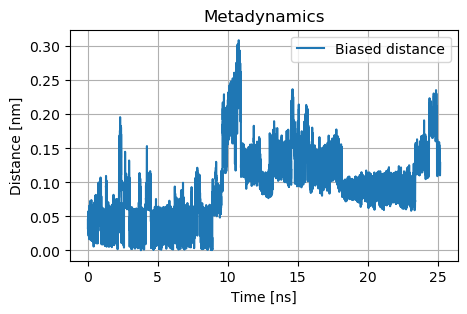

In [3]:
with open("HILLS") as f:
    lines = (line for line in f if not line.startswith('#'))
    HILLS = np.loadtxt(lines)

bias_times = []
bias_dist = []

for i in range(len(HILLS)):
    bias_times.append(HILLS[i][0]*0.001)
    bias_dist.append(HILLS[i][1])


plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(bias_times, bias_dist, label=r'Biased distance')
plt.title("Metadynamics")
plt.grid()
plt.ylabel("Distance [nm]")
plt.xlabel("Time [ns]")
plt.legend(loc="best")

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2564/3726767842.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_hills = plumed.read_as_pandas("HILLS")


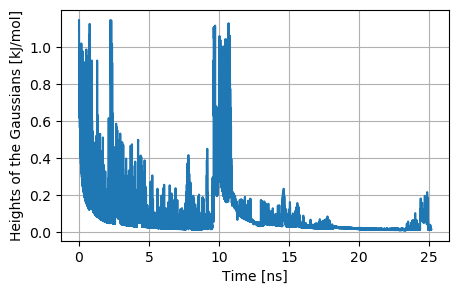

In [4]:
# EQUIVALENT WAY OF OBTAINING GAUSSIANS' HEIGHTS

# This is just a reconstruction of the Gaussians' height from the printed bias potential 
# arr = [math.exp(-data_colvar["metad.bias"][i]/8) for i in range(len(data_colvar["metad.bias"]))]
# plt.plot(data_colvar["time"], arr)
# plt.plot(data_hills["time"]*0.001, data_hills["height"])
# plt.grid()


data_hills = plumed.read_as_pandas("HILLS")
plt.plot(data_hills["time"]*0.001, data_hills["height"])
plt.xlabel("Time [ns]")
plt.ylabel("Heights of the Gaussians [kJ/mol]")
plt.grid()
# We convert the time steps in nanoseconds: the first column of the HILLS file is expressed in ps. 
# The data of HILLS are represented with a "stride" of ( 0.2 fs * 1000 = 2 ps). 
# We can simply multiply by 0.001.  

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2564/3918306086.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar = plumed.read_as_pandas("COLVAR")


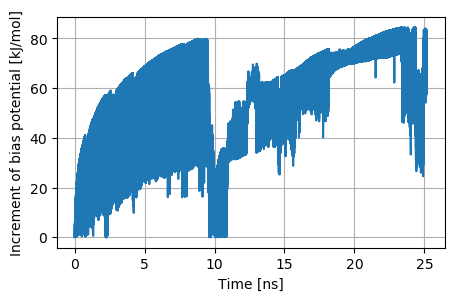

In [5]:
data_colvar = plumed.read_as_pandas("COLVAR")
plt.plot(data_colvar["time"]*0.001, data_colvar["metad.bias"])
plt.xlabel("Time [ns]")
plt.ylabel("Increment of bias potential [kJ/mol]")
plt.grid()

# Interpretation of the plots

The height must be computed with the bias at the previous step. In fact, you can write the updating law of the bias employing the insertion time as a label. A good notation should in fact be:
$$
B_{t'+\tau_G}(\{s_i(t)\}, t)=B_{t'}(\{s_i(t)\}, t)+W\exp{\left(-\frac{B_{t'}(\{s_i(t)\}, t)}{\Delta T}\right)}\exp{\left(-\sum_{i=1}^{N}\frac{(s_i(t)-s_i(t'))^2}{2\sigma_i^2}\right)}
$$

### Metadynamics bias
The increment of the bias potential at time $t>t'$: 
$$
W \exp{\left(-\frac{B_{t'}(\{s_i(t)\}, t)}{\Delta T}\right)} \exp{\left(-\sum_{i=1}^{N}\frac{(s_i(t)-s_i(t'))^2}{2\sigma_i^2}\right)}
$$
where $t'$ is a multiple of $\tau_G$. I think that this increment can go to zero when the distance $s_i(t)-s_i(t')$ is huge, namely, when the CV has deviated considerably from the value of the same CV at the time of Gaussian insertion. This difference $s_i(t)-s_i(t')$ increases when we pass from one basin to another.  This explains the drop of the bias in around 10 ns. 


### Plot of the heights of the Gaussians
Around 10 ns, we have a clear change in the height of the Gaussians, which originally is set equal to 1. This change is clearly related to the exploration of another basin. We said that around 10 ns the bias added drops to zero, but this determines an increase in the height since the factor 
$$
W\exp{\left(-\frac{B_{t'}(\{s_i(t)\}, t)}{\Delta T}\right)}
$$
goes to $W$. 



## Assessment of convergence

We use the tool `sum_hills` to judge the convergence of the free energy profile as a function of the simulated time. With this command we generate many free energy files (`fes`), each one containing the estimate of the free energy up to that point in time.
```
plumed sum_hills --hills HILLS --stride 100 --mintozero
```

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2564/1855929750.py:4: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2564/1855929750.py:4: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2564/1855929750.py:4: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2564/1855929750.py:4: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2564/1855929750.py:4: UserWarning: cannot load PLUMED instance, conversions will not be avail

Text(0, 0.5, 'Free energies [kJ/mol]')

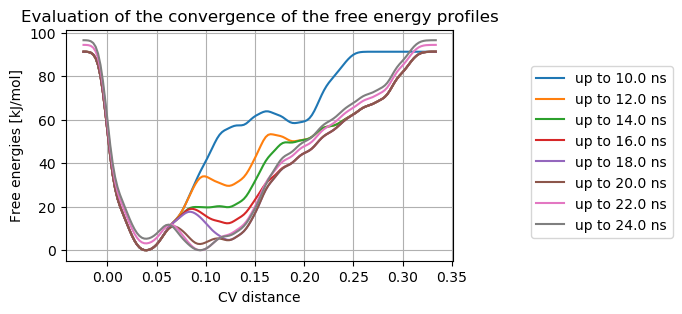

In [8]:
# Plot the fes all together
for i in range(50, 121,10):   
    # import fes file into pandas dataset
    data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")

    plt.plot(data["d1"],data["file.free"], label="up to "+str(i  * 0.2)+" ns")
plt.grid()
plt.title("Evaluation of the convergence of the free energy profiles")
#plt.legend(loc="best")
plt.xlabel(r"CV distance")
plt.legend(loc=[1.2, 0.1])
plt.ylabel("Free energies [kJ/mol]")

One of the great difficulties we have to face when no knowledge is provided about the free energy landscape, is that even if the system may seem to explore different regions of phase space, it can be stuck inside a single basin. This is insanely difficult to assess.

The dynamics of the CV at a certain point should be diffusive and fluctuations should become more and more important.  

# Free energy difference as a function of time